##### In this notebook, we will build one clean global dataset and create safe splits (train/val/test/QA) that avoid leakage.

In [1]:
# Set up project imports and load all per-month product-level tables

from pathlib import Path
import sys
import pandas as pd

# Find project root and src folder
cwd = Path.cwd()
project_root = None
for path in [cwd, *cwd.parents]:
    if (path / "src").is_dir():
        project_root = path
        break

if project_root is None:
    raise FileNotFoundError("Could not find project root containing 'src' folder.")

SRC_DIR = project_root / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from config import INTERIM_DATA_DIR
from preprocessing import normalize_text  # imported for later use if needed

print("Project root:", project_root)
print("Interim data dir:", INTERIM_DATA_DIR)

# Load all products_joined_*.parquet files
month_files = sorted(INTERIM_DATA_DIR.glob("products_joined_export_shopper=*.parquet"))
print("\nFound per-month product files:", len(month_files))
for p in month_files:
    print(" -", p.name)

products_per_month = [pd.read_parquet(p) for p in month_files]
products_all = pd.concat(products_per_month, ignore_index=True)

print("\nCombined products_all shape:", products_all.shape)
print("Rows per month in products_all:")
print(products_all["month"].value_counts().sort_index())
products_all.head(10)

Project root: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
Interim data dir: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim

Found per-month product files: 10
 - products_joined_export_shopper=AUG-24.parquet
 - products_joined_export_shopper=DEC-24.parquet
 - products_joined_export_shopper=FEB-25.parquet
 - products_joined_export_shopper=JAN-25.parquet
 - products_joined_export_shopper=JUL-24.parquet
 - products_joined_export_shopper=JUN-24.parquet
 - products_joined_export_shopper=MAY-24.parquet
 - products_joined_export_shopper=NOV-24.parquet
 - products_joined_export_shopper=OCT-24.parquet
 - products_joined_export_shopper=SEP-24.parquet

Combined products_all shape: (32803, 9)
Rows per month in products_all:
month
export_shopper=AUG-24    1621
export_shopper=DEC-24    3074
export_shopper=FEB-25     561
export_shopper=JAN-25    2437
export_shopper=JUL-24    2204
export_shopper=JUN-24    7568
export_

,event_id,event_type,start_time_local,remove_amazon,month,product_text_raw,product_text_norm,label_raw,label
0,3ac673ccc92f457cfa46657b30322aab,Product Detail,2024-08-24 14:44:00.378,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",export_shopper=AUG-24,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",1 5 gram x 50 vial convenient super glue wegla...,10,0
1,00e9cfe2727b2e3136f61d806d3378c8,Product Detail,2024-08-24 07:26:18.242,10 Sets 14-16 Inch Baby Doll Clothes Dress Out...,export_shopper=AUG-24,10 Sets 14-16 Inch Baby Doll Clothes Dress Out...,10 sets 14 16 inch baby doll clothes dress out...,10,0
2,4e8021c4d566e760de9582df1c404212,Basket View,2024-08-24 16:43:07.41,"100PCS Swivel Snap Hooks with Key Rings, Premi...",export_shopper=AUG-24,"100PCS Swivel Snap Hooks with Key Rings, Premi...",100pcs swivel snap hooks with key rings premiu...,0,0
3,91211b525bd96dc26e6a11bc37b985ce,Product Detail,2024-08-04 20:00:45.796,100S JEWELRY Tungsten Rings For Men Wedding Ba...,export_shopper=AUG-24,100S JEWELRY Tungsten Rings For Men Wedding Ba...,100s jewelry tungsten rings for men wedding ba...,1,1
4,e2de3919b4898aa66f7131c25309e425,Product Detail,2024-08-16 22:09:10.362,104 Pieces Self Adhesive Chenille Letter Patch...,export_shopper=AUG-24,104 Pieces Self Adhesive Chenille Letter Patch...,104 pieces self adhesive chenille letter patch...,0,0
5,c18fa71c1124ead8a23ad98dea0d9b0a,Basket View,2024-08-25 01:49:07.556,12 Pairs 18K Gold Plated Surgical Stainless St...,export_shopper=AUG-24,12 Pairs 18K Gold Plated Surgical Stainless St...,12 pairs 18k gold plated surgical stainless st...,1,1
6,80f9e88c14c06a7072a88f3507183168,Product Detail,2024-08-10 13:49:16.612,16 Pack Sole Protector for High Heel Shoes Red...,export_shopper=AUG-24,16 Pack Sole Protector for High Heel Shoes Red...,16 pack sole protector for high heel shoes red...,10,0
7,e866c1bb3faaa231b4552f29fdd072e7,Basket View,2024-08-17 19:52:31.444,16 Pairs Dangle Earrings For Women Trendy Diam...,export_shopper=AUG-24,16 Pairs Dangle Earrings For Women Trendy Diam...,16 pairs dangle earrings for women trendy diam...,1,1
8,cf27ab1ccf99584c38d9ca05c3b45015,Product Detail,2024-08-24 09:53:45.571,16G 8mm Surgical Steel Nose Septum Horseshoe H...,export_shopper=AUG-24,16G 8mm Surgical Steel Nose Septum Horseshoe H...,16g 8mm surgical steel nose septum horseshoe h...,0,0
9,3083874cc5bccae02365571448bad98c,Product Detail,2024-08-27 19:22:33.485,18K White Gold Plated Round Square Cubic Zirco...,export_shopper=AUG-24,18K White Gold Plated Round Square Cubic Zirco...,18k white gold plated round square cubic zirco...,1,1


##### De-duplicate and Resolve Label Conflicts

* Checks how many duplicates and cross-month conflicts exist in the data.
* Drops any products whose label **disagrees across months** (to avoid noisy supervision).
* Collapses the data to **one row per normalized product** globally.
* Shows the updated class balance and a small sample of the cleaned data.

Total rows in products_all          : 32803
Unique product_text_norm in products_all: 19767

Number of product_text_norm values with conflicting labels across months: 0
Rows after dropping conflicts: 32803
Global product-level rows (unique products): 19767
Unique product_text_norm in products_global: 19767

Class balance in products_global (0=non-fashion, 1=fashion):
label=0: 3165 products (16.01%)
label=1: 16602 products (83.99%)


,product_text_raw,product_text_norm,label,month
9897,001B 3000A Car Jump Starter Battery Pack (up t...,001b 3000a car jump starter battery pack up to...,0,export_shopper=JUN-24
9898,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,0,export_shopper=JUN-24
23729,1/2 Ct Diamond Stud Earrings 14k Yellow Gold F...,1 2 ct diamond stud earrings 14k yellow gold f...,1,export_shopper=NOV-24
17465,1-2 Pairs 925 Sterling Silver Mens Earrings Cu...,1 2 pairs 925 sterling silver mens earrings cu...,1,export_shopper=MAY-24
9899,"1/2"""" x 18"""" Zirconia Sanding Belts for Belt S...",1 2 x 18 zirconia sanding belts for belt sande...,0,export_shopper=JUN-24
0,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",1 5 gram x 50 vial convenient super glue wegla...,0,export_shopper=AUG-24
9900,"1/6 Scale Female Clothes, Female Black Leather...",1 6 scale female clothes female black leather ...,1,export_shopper=JUN-24
9901,"1/6 Scale Female Clothes, Female Sports Underw...",1 6 scale female clothes female sports underwe...,1,export_shopper=JUN-24
9902,"1/6 Scale Female Clothes, Female Sports Underw...",1 6 scale female clothes female sports underwe...,1,export_shopper=JUN-24
7694,1.75mm Normal PLA 4 Most Basic Colors Bundle P...,1 75mm normal pla 4 most basic colors bundle p...,0,export_shopper=JUL-24


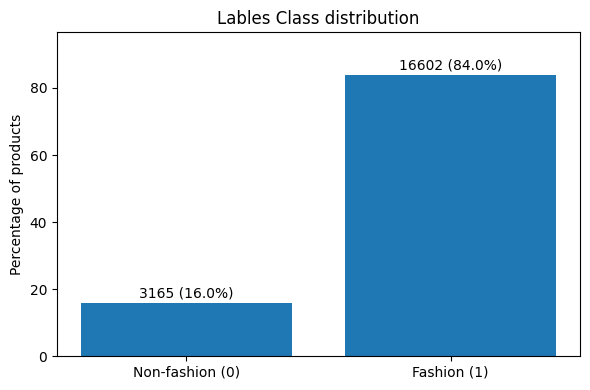

In [11]:
# Check cross-month duplicates and conflicts on product_text_norm,
# then build a global product-level table.

# 1) How many unique normalized texts vs rows?
n_rows_all = len(products_all)
n_unique_all = products_all["product_text_norm"].nunique()
print(f"Total rows in products_all          : {n_rows_all}")
print(f"Unique product_text_norm in products_all: {n_unique_all}")

# 2) Detect products that have both labels 0 and 1 across any months
label_counts_global = (
    products_all.groupby("product_text_norm")["label"].nunique()
)
conflict_texts_global = label_counts_global[label_counts_global > 1].index

print(f"\nNumber of product_text_norm values with conflicting labels across months: {len(conflict_texts_global)}")

# 3) Drop conflicting products entirely
products_no_conflicts = products_all[
    ~products_all["product_text_norm"].isin(conflict_texts_global)
].copy()

print("Rows after dropping conflicts:", len(products_no_conflicts))

# 4) Deduplicate globally: one row per product_text_norm.
#    Keep the earliest start_time_local so we have a stable "first_seen" notion.
products_no_conflicts = products_no_conflicts.sort_values(
    ["product_text_norm", "start_time_local"],
    na_position="last",
)

products_global = products_no_conflicts.drop_duplicates(
    subset=["product_text_norm"],
    keep="first",
).copy()

print("Global product-level rows (unique products):", len(products_global))
print("Unique product_text_norm in products_global:", products_global["product_text_norm"].nunique())

# 5) Class balance in the global product-level dataset
cls_counts_global = products_global["label"].value_counts().sort_index()
cls_pct_global = products_global["label"].value_counts(normalize=True).sort_index() * 100

print("\nClass balance in products_global (0=non-fashion, 1=fashion):")
for k in cls_counts_global.index:
    print(f"label={k}: {cls_counts_global[k]} products ({cls_pct_global[k]:.2f}%)")

display(products_global[["product_text_raw", "product_text_norm", "label", "month"]].head(10))

# === NEW: visualize global class distribution in percentages ===
import matplotlib.pyplot as plt

# Prepare data for plotting
x_labels = ["Non-fashion (0)", "Fashion (1)"]
counts = [cls_counts_global.get(0, 0), cls_counts_global.get(1, 0)]
percents = [cls_pct_global.get(0, 0), cls_pct_global.get(1, 0)]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(x_labels, percents)

ax.set_ylabel("Percentage of products")
ax.set_title("Lables Class distribution")

# Add counts and percentages on top of each bar
for bar, count, pct in zip(bars, counts, percents):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{count} ({pct:.1f}%)",
        ha="center",
        va="bottom"
    )

ax.set_ylim(0, max(percents) * 1.15)
plt.tight_layout()
plt.show()

### Results summary so far is as follows

1.  **We now have a clean, de-duplicated, product-level dataset.**
    * `products_global` is our master table for modeling.
    * Every normalized product name appears once.
    * No label conflicts.
    * This avoids:
        * target leakage from the same product appearing in both train and test,
        * over-weighting frequent products that show up in many months.

2.  **The strong fashion skew is something we will handle in evaluation.**
    * We'll focus on precision/recall and PR curves, not just accuracy.
    * We'll likely tune the decision threshold rather than blindly use 0.5.
    * We won't treat this class ratio as "real-world prior" for probabilities; it's a label-sampling artifact.

3.  **We're ready to design splits safely.**
    Since each `product_text_norm` now appears only once, group-aware splitting by product text becomes trivial:
    * if a product is in train, it can't appear in val/test – it's already guaranteed.
    Now the main design choice is **time-aware splitting** based on month, so that:
    * earlier months $\to$ train,
    * later months $\to$ validation/test,
    * and maybe hold out the very latest month(s) for manual QA.

In [3]:
# Save the global product-level dataset to data/processed

from config import PROCESSED_DATA_DIR

PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

products_global_path = PROCESSED_DATA_DIR / "products_global.parquet"
products_global.to_parquet(products_global_path, index=False)

print("Saved products_global to:", products_global_path)
print("Shape:", products_global.shape)

Saved products_global to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/products_global.parquet
Shape: (19767, 9)


In [4]:
# Inspect product counts per month in the global product-level dataset

products_per_month_global = products_global["month"].value_counts().sort_index()
print("Products per month in products_global:")
print(products_per_month_global)

len(products_global), products_global.head(5)

Products per month in products_global:
month
export_shopper=AUG-24     464
export_shopper=DEC-24     797
export_shopper=FEB-25      64
export_shopper=JAN-25     415
export_shopper=JUL-24     540
export_shopper=JUN-24    6694
export_shopper=MAY-24    6263
export_shopper=NOV-24    1268
export_shopper=OCT-24    2243
export_shopper=SEP-24    1019
Name: count, dtype: int64


(19767,
                                event_id      event_type  \
 9897   607abbbceccb6b89eeb997e15db959ed  Product Detail   
 9898   58f144d19ec6229a4a2a4ed4c4eeaba5  Product Detail   
 23729  cf12ab056ae7bc14be92c626ad2aa1c3    Product List   
 17465  a3c2dcf0e78f565e3f0ad98d32556944  Product Detail   
 9899   a9ec712af1b9077281d8e4555de0d5e4  Product Detail   
 
               start_time_local  \
 9897   2024-06-01 10:03:39.576   
 9898   2024-06-10 07:32:37.247   
 23729  2024-11-28 19:18:20.554   
 17465  2024-05-21 03:12:32.923   
 9899   2024-06-11 13:54:26.333   
 
                                            remove_amazon  \
 9897   001B 3000A Car Jump Starter Battery Pack (up t...   
 9898   012 Jump Starter Battery Pack, 4000A Peak Car ...   
 23729  1/2 Ct Diamond Stud Earrings 14k Yellow Gold F...   
 17465  1-2 Pairs 925 Sterling Silver Mens Earrings Cu...   
 9899   1/2"" x 18"" Zirconia Sanding Belts for Belt S...   
 
                        month  \
 9897   export_sh

Rows with missing split: 0

Products per split:
split
test      2544
train    13961
val       3262
Name: count, dtype: int64

Products per split (percent):
test: 2544 products (12.87%)
train: 13961 products (70.63%)
val: 3262 products (16.50%)

Products per split and label:
label     0      1
split             
test    445   2099
train  2246  11715
val     474   2788


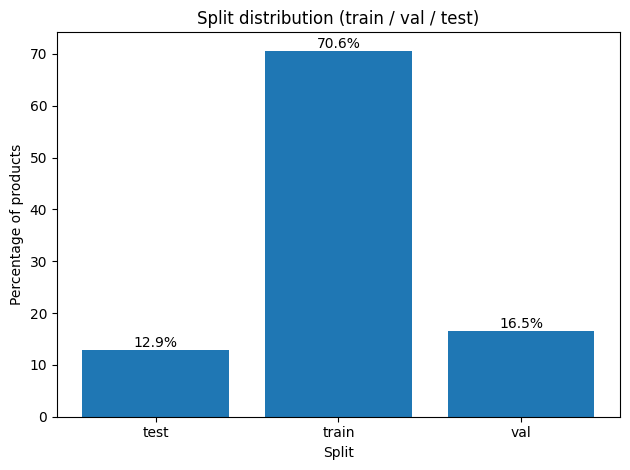


Saved products_with_splits to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/products_with_splits.parquet


In [6]:
# Define time-aware splits, inspect counts, plot percentages, and save to processed

from config import PROCESSED_DATA_DIR
import matplotlib.pyplot as plt

# Time-aware split mapping (months -> split)
split_map = {
    "export_shopper=MAY-24": "train",
    "export_shopper=JUN-24": "train",
    "export_shopper=JUL-24": "train",
    "export_shopper=AUG-24": "train",
    "export_shopper=SEP-24": "val",
    "export_shopper=OCT-24": "val",
    "export_shopper=NOV-24": "test",
    "export_shopper=DEC-24": "test",
    "export_shopper=JAN-25": "test",
    "export_shopper=FEB-25": "test",
}

# Assign split
products_global["split"] = products_global["month"].map(split_map)

# Sanity check
missing_splits = products_global["split"].isna().sum()
print("Rows with missing split:", missing_splits)

print("\nProducts per split:")
split_counts = products_global["split"].value_counts().sort_index()
print(split_counts)

split_pct = products_global["split"].value_counts(normalize=True).sort_index() * 100

print("\nProducts per split (percent):")
for s in split_counts.index:
    print(f"{s}: {split_counts[s]} products ({split_pct[s]:.2f}%)")

print("\nProducts per split and label:")
print(
    products_global.groupby(["split", "label"])["product_text_norm"]
    .count()
    .unstack(fill_value=0)
)

# Bar chart: split percentages
splits = split_pct.index.tolist()
values = [split_pct[s] for s in splits]
x_pos = range(len(splits))

plt.figure()
bars = plt.bar(x_pos, values)
plt.xticks(x_pos, splits)
plt.ylabel("Percentage of products")
plt.xlabel("Split")
plt.title("Split distribution (train / val / test)")

# Add percentage labels on top of bars
for x, height in zip(x_pos, values):
    plt.text(x, height, f"{height:.1f}%", ha="center", va="bottom")

plt.grid(False)
plt.tight_layout()
plt.show()

# Save final dataset with splits
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
products_with_splits_path = PROCESSED_DATA_DIR / "products_with_splits.parquet"
products_global.to_parquet(products_with_splits_path, index=False)

print("\nSaved products_with_splits to:", products_with_splits_path)